In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import QuantileTransformer

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
het_cols = ['Si','Al','P','Ge','B','V','Be','Ga','Ti'] # heteroatoms in the dataset

def check_nans(df):
    return f'Number of NaNs: {df.isna().sum()}'

def check_infs(df):
    return f'Number of Infs: {df.isin([np.inf, -np.inf]).sum()}'

In [10]:
df = pd.read_excel('ZEOSYN.xlsx').drop(columns = ['Unnamed: 0'])
df = df[~df['doi'].isna()] # keep only non-empty rows
df['T'] = df[het_cols].sum(axis=1)

High val: 400.00000000000006
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

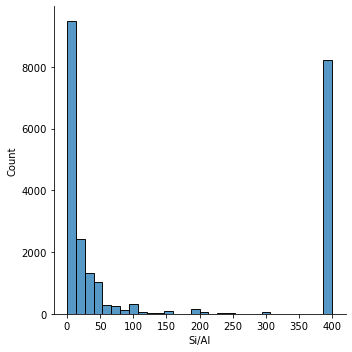

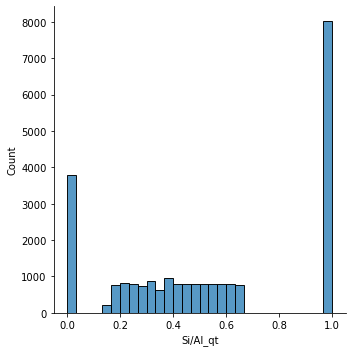

In [4]:
# Si/Al ratio
x, y = 'Si', 'Al'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.98)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 400.0

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 400.0

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 1.7179967159277212
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

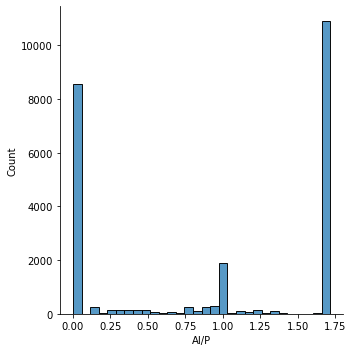

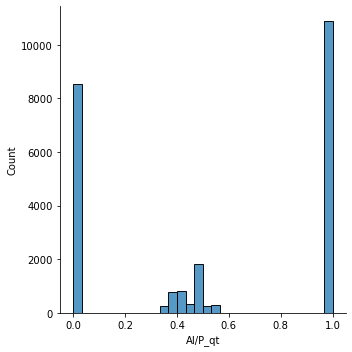

In [5]:
# Al/P ratio
x, y = 'Al', 'P'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.99)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 1.7

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 1.7

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 24.999999999999986
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

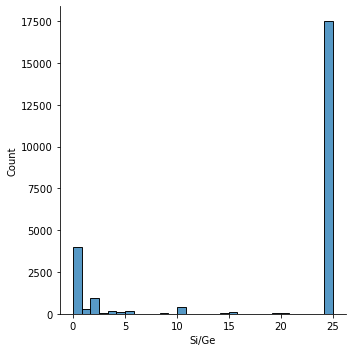

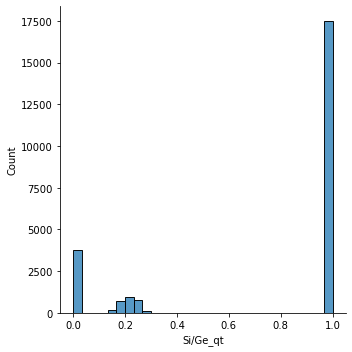

In [6]:
# Si/Ge ratio
x, y = 'Si', 'Ge'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.95)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 100.0

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 100.0

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 250.00000000000003
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

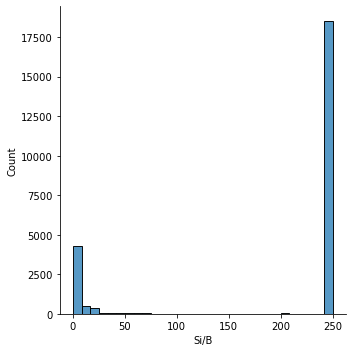

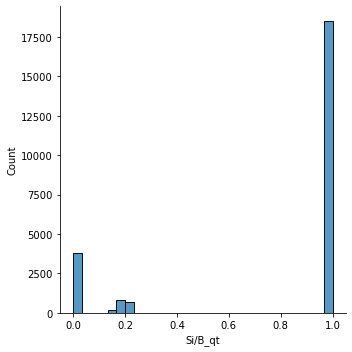

In [7]:
# B/Si ratio
x, y = 'Si', 'B'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.99)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 100.0

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 100.0

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 1.920999102706711
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

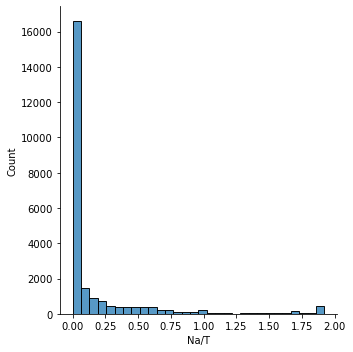

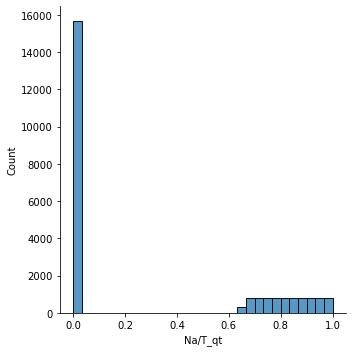

In [19]:
# Na/T ratio
x, y = 'Na', 'T'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.95)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 1.9

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 1.9

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 5.333333333333333
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

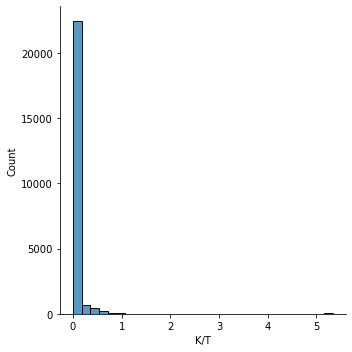

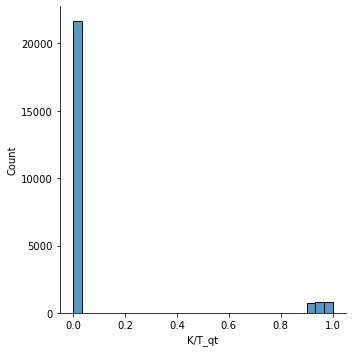

In [25]:
# Na/T ratio
x, y = 'K', 'T'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.99)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 5.3

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 5.3

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 2.4341677246909406
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

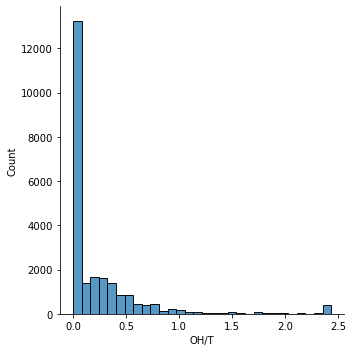

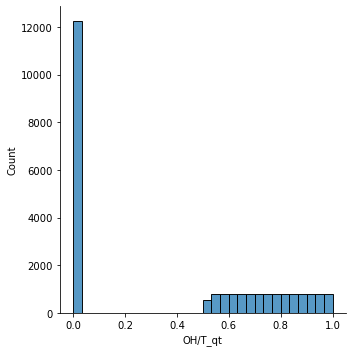

In [32]:
# OH/T ratio
x, y = 'OH', 'T'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.97)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 2.4

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 2.4

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 200.00000000000006
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

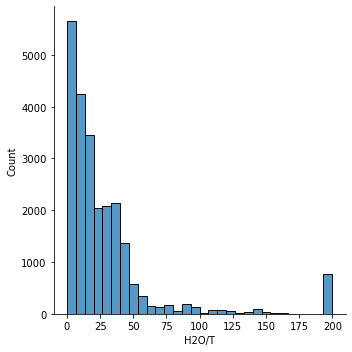

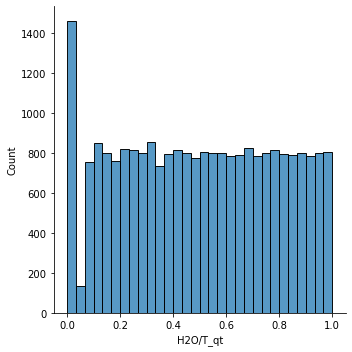

In [41]:
# H2O/T ratio
x, y = 'H2O', 'T'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.99)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 200

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 200

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()

High val: 6.097582682238018
Number of NaNs: 0
Number of Infs: 0


<Figure size 1080x504 with 0 Axes>

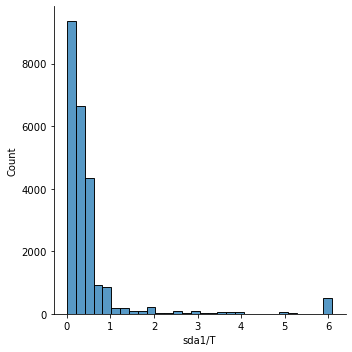

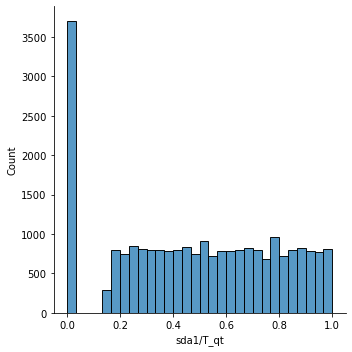

In [48]:
# H2O/T ratio
x, y = 'sda1', 'T'
ratio = f"{x}/{y}"
df[ratio] = df[x]/df[y]

# Fix NaNs from 0.0/0.0
idxs = df[df[ratio].isna()].index
for idx in idxs:
    df.loc[idx, ratio] = 0. # set to 0.0

# Fix infs
idxs = df[df[ratio] == np.inf].index # NaNs from 0.0/0.0
high_val = np.quantile(df[(df[ratio] != np.inf) & (df[ratio] != 0.)][ratio], 0.98)
print('High val:', high_val)
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 6.

# Set upper limit
idxs = df[df[ratio] >= high_val].index # High values
for idx in idxs:
    df.loc[idx, ratio] = high_val # set to about 6.

print(check_nans(df[ratio]))
print(check_infs(df[ratio]))

# Quantile transform
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
df[f'{ratio}_qt'] = qt.fit_transform(np.array(df[ratio]).reshape(-1, 1)).reshape(-1)
with open(f'{x}{y}_qt.pkl', 'wb') as f:
    pickle.dump(qt, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{x}{y}_qt.pkl', 'rb') as f:
    qt = pickle.load(f)

plt.figure(figsize=(15,7))
sns.displot(df[ratio], bins=30) 
sns.displot(df[f'{ratio}_qt'], bins=30) 
plt.show()